In [6]:
from Utils.Config import DATA_DIR
from Utils.Config import CHARTS_DIR
from Utils import dataUtils
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import os

In [50]:
path = dataUtils.getDataPaths(2)
data = dataUtils.concat_dfs("prices", path)

<Axes: >

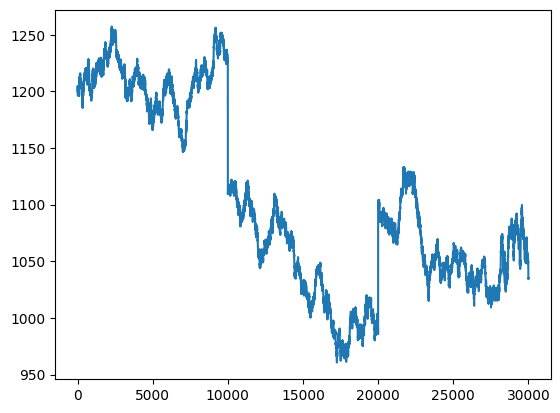

In [51]:
data["ORCHIDS"].plot()

Feature Analysis EDA

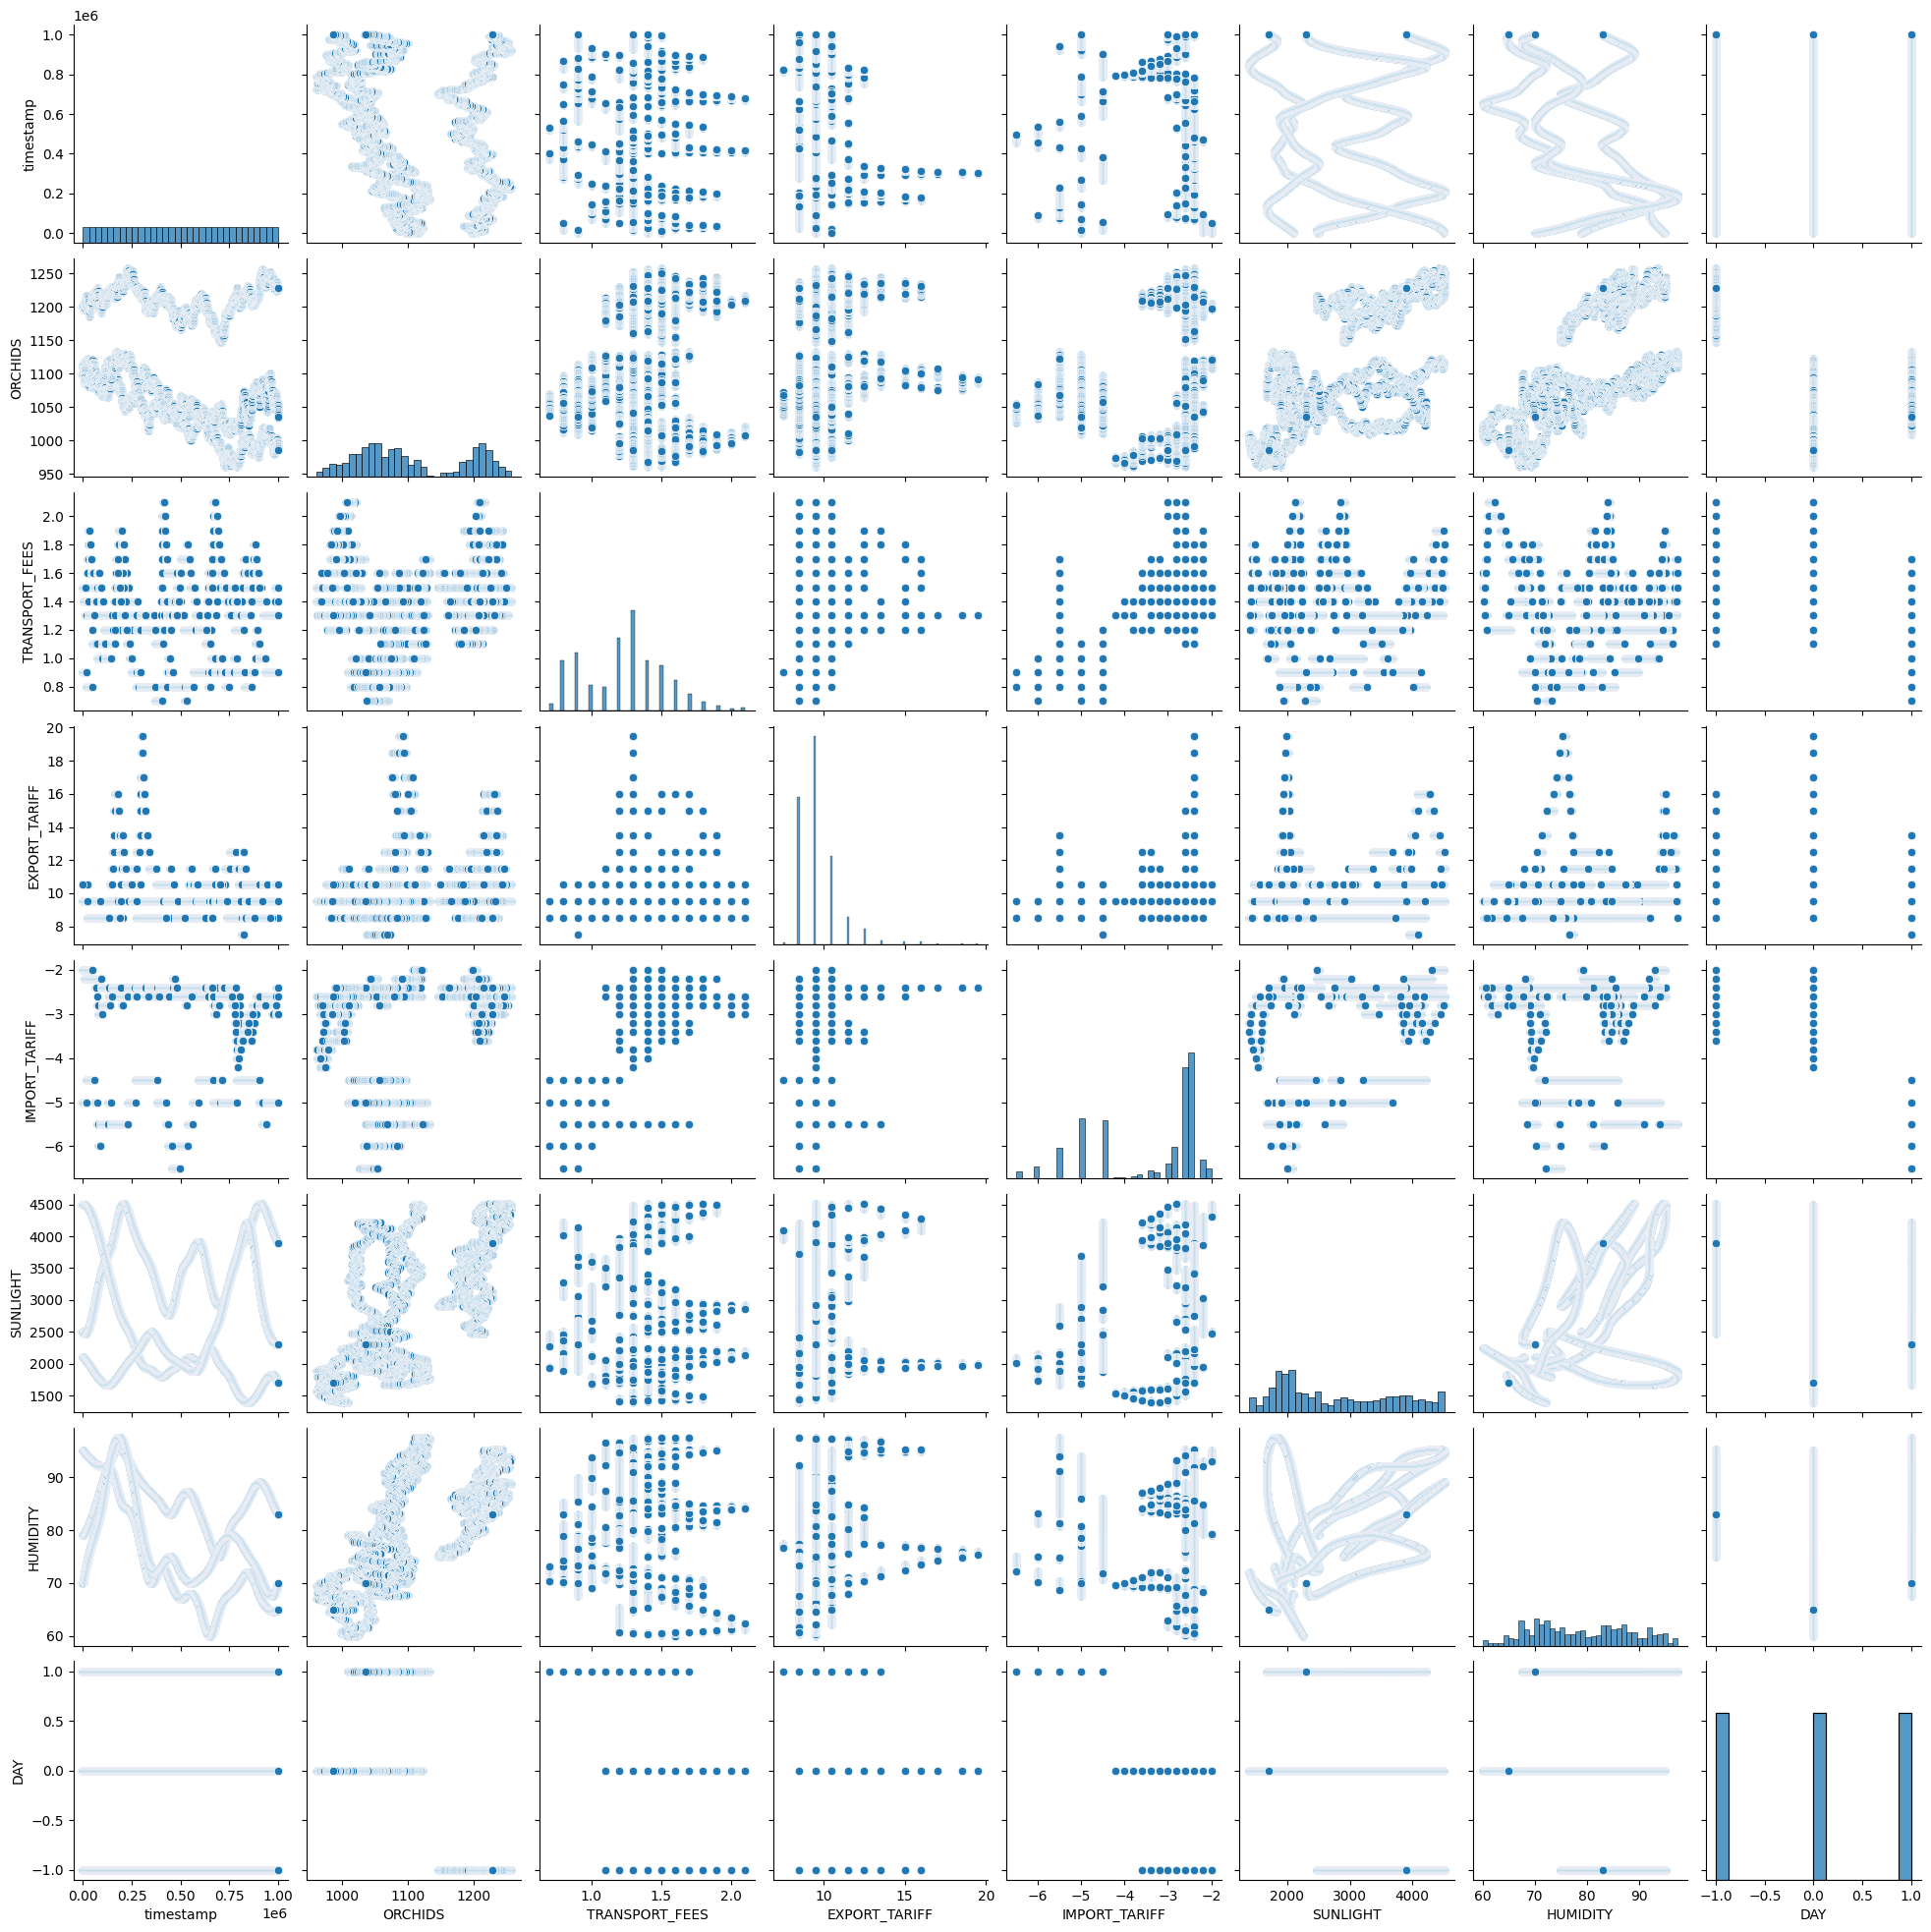

In [52]:
import seaborn as sns

features = ["ORCHIDS","TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"]
sns.pairplot(data)

Linear Regression Parameters to predict the price of orchids

In [66]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


data["ET"] = data["EXPORT_TARIFF"].rolling(100).mean()
data["TFees"] = data["TRANSPORT_FEES"].rolling(100).mean()
data["IT"] = data["IMPORT_TARIFF"].rolling(100).mean()
data["S"] = data["SUNLIGHT"].rolling(100).mean()
data["H"] = data["HUMIDITY"].rolling(100).mean()

data.dropna(inplace=True)

X = data[["TFees", "ET", "IT", "S", "H"]]
y = data["ORCHIDS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42,shuffle=False)
model = Lasso()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(mean_squared_error(y_test, preds))

7756.553650840419


[0.         5.35867505 0.         0.05419601 2.67292079]


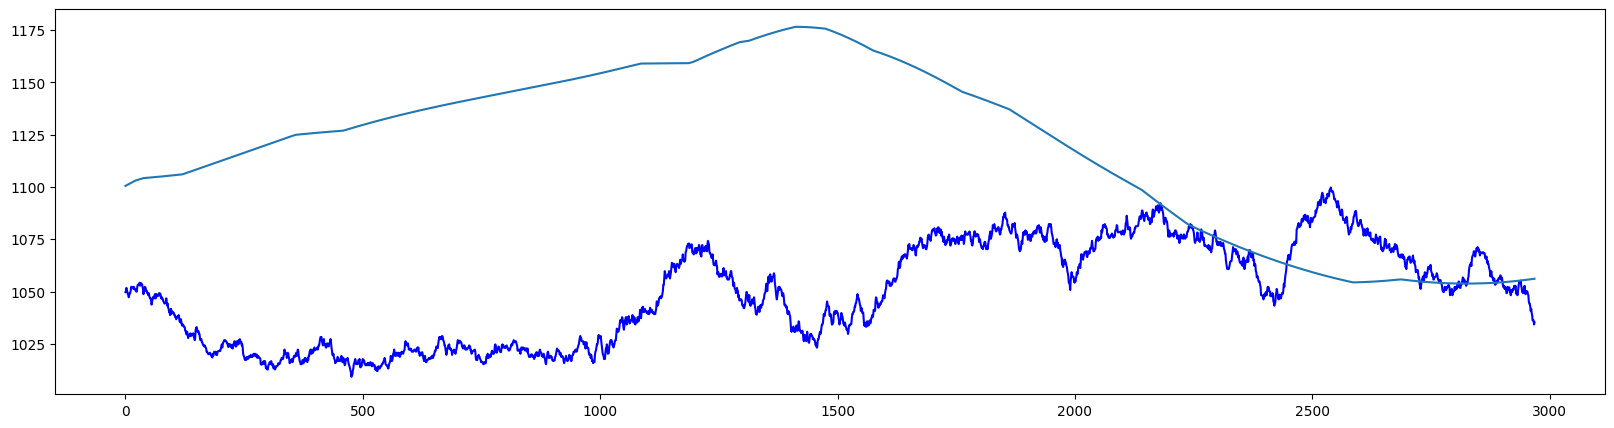

In [67]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds)

print(model.coef_)

Feature Enginering and Model Improvement

0.4477008911684581

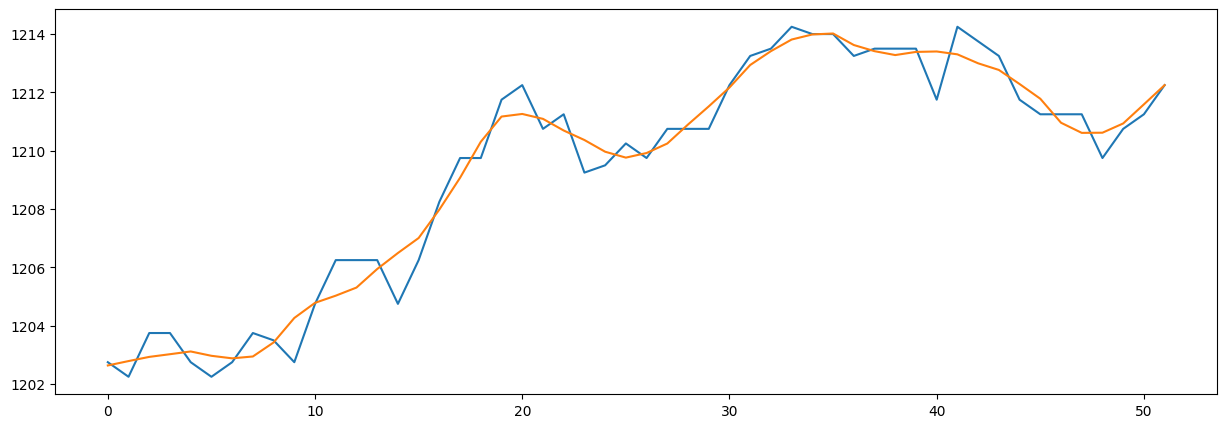

In [166]:
#Filtering ORCHIDS:

sig = data.ORCHIDS.values[:200]
window = 11
savgol_preds = dataUtils.savitzky_golay(sig,window,order=3)
fig = plt.figure(figsize=(15,5))
plt.plot(sig)
plt.plot(savgol_preds)

data["H_fil"] = sc.signal.savgol_filter(data.HUMIDITY, window_length=window, polyorder=4, mode="nearest")
data["S_fil"] = sc.signal.savgol_filter(data.SUNLIGHT, window_length=window, polyorder=4, mode="nearest")
data["savgol_price"] = savgol_preds
data["savgol_gradient"] = np.gradient(data.savgol_price)

data["ORCHIDS_SMA25"] = data["ORCHIDS"].rolling(25).mean()
data.dropna(inplace=True)

mean_squared_error(sig,savgol_preds)


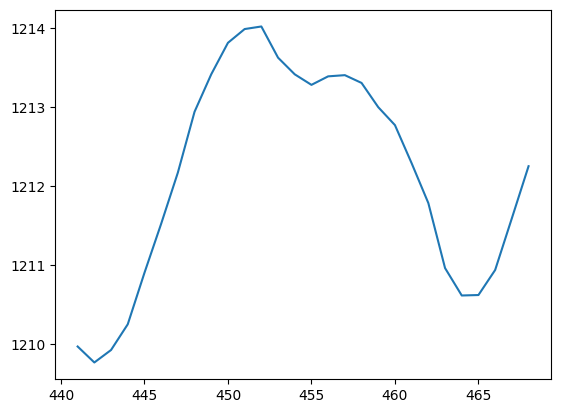

In [167]:
plt.plot(data.savgol_price)

In [174]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = data[["TRANSPORT_FEES", "EXPORT_TARIFF", "IMPORT_TARIFF", "SUNLIGHT", "HUMIDITY"]]
y = data["ORCHIDS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=False)
model = Lasso()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(mean_squared_error(y_test, preds))

8.996024517987925


[ 0.          0.         -0.          0.08717167  0.        ]


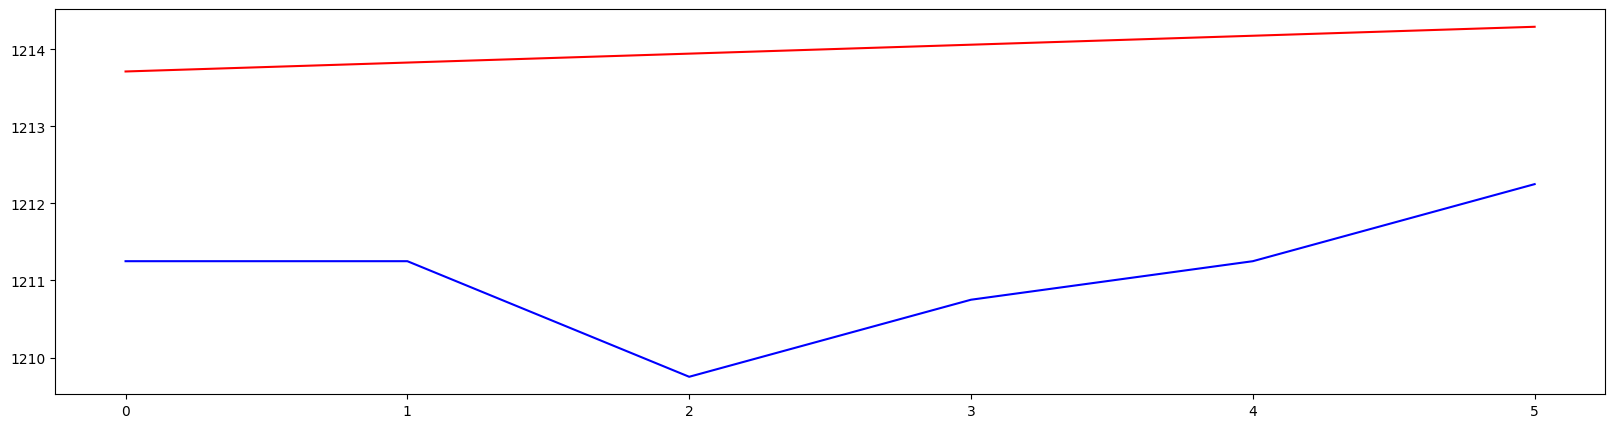

In [175]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.values, color="blue")
plt.plot(preds, color = "red")

print(model.coef_)

In [170]:
savgol_preds = data["savgol_price"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


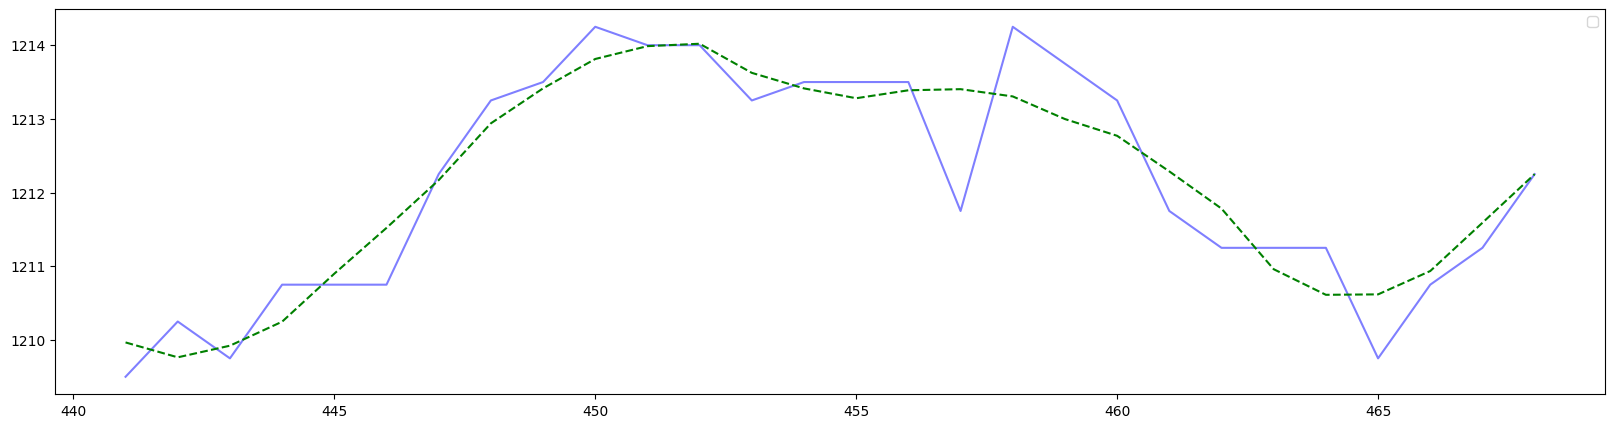

In [171]:
fig = plt.figure(figsize=(20,5))
plt.plot(data.ORCHIDS, color="blue", alpha=0.5)
plt.plot(data.savgol_price, color="green", linestyle="dashed")
plt.legend()

- Use the gradient of the curve to sell or buy if price is bellow or aboev predictions and slope close to 0

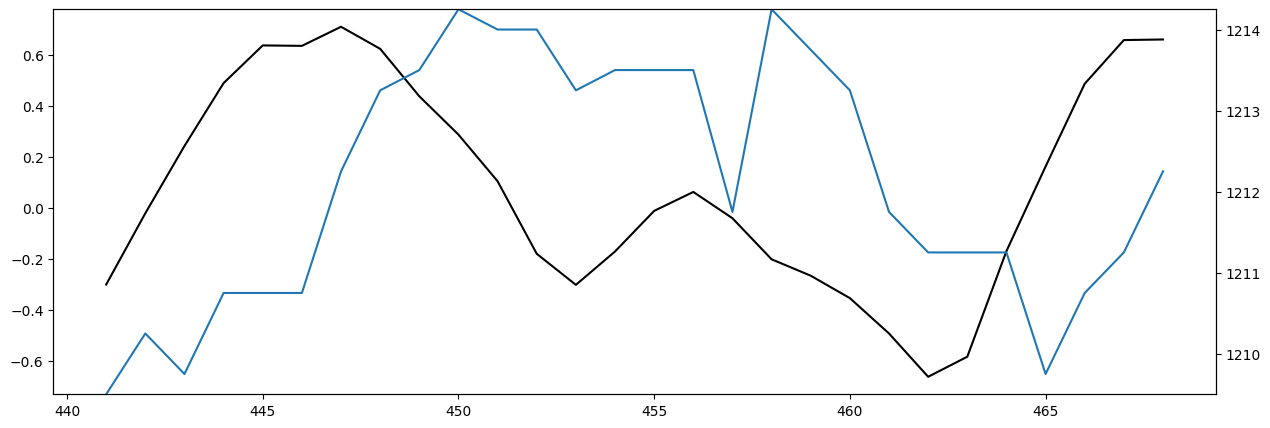

In [172]:
x = np.arange(0,len(savgol_preds))
dx = np.diff(x)
dy = np.diff(y)
d = np.gradient(savgol_preds)


fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()  
ax2.set_ylim(data.ORCHIDS.min(),data.ORCHIDS.max())
ax1.plot(data.savgol_gradient, color="black")
ax2.plot(y)

#plt.plot(savgol_preds)
savgol_signals = y

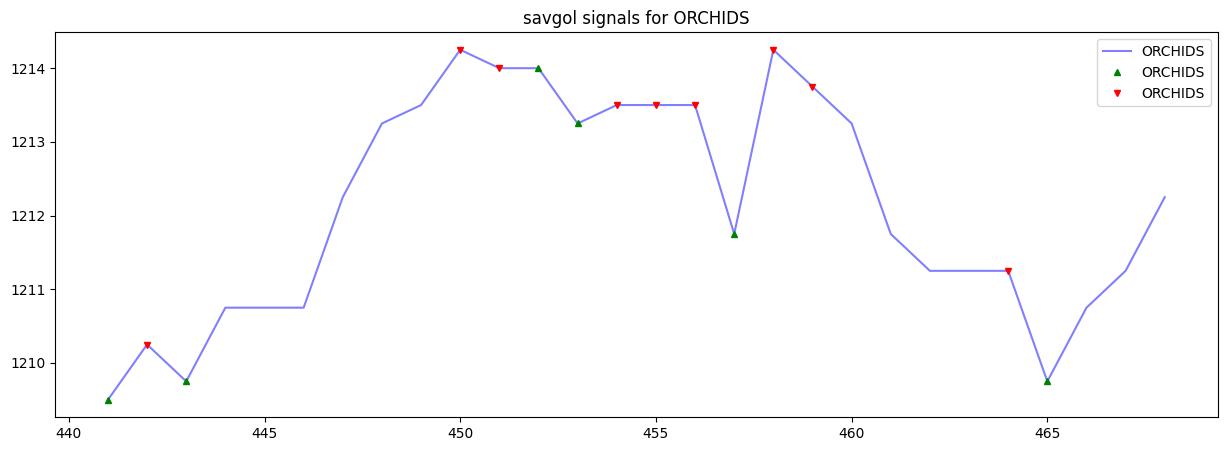

In [173]:
umbral_slope = 0.33
umbral_orchids = 100

# Aplicar filtro y crear la columna signal
data['signal_sell'] = np.where(
    (np.isclose(data['savgol_gradient'], 0, atol=umbral_slope)) & 
    (data['ORCHIDS'] > data["savgol_price"]),
    1,
    0
)
data['signal_buy'] = np.where(
    (np.isclose(data['savgol_gradient'], 0, atol=umbral_slope)) & (data['ORCHIDS'] < data["savgol_price"]),
    1,
    0
)

fig = plt.figure(figsize=(15,5))
data = data[0:100]
data["ORCHIDS"].plot(color="blue", alpha=0.5)
data["ORCHIDS"][data.signal_buy==1].plot(marker="^", markersize=5, color='g',linestyle='')
data["ORCHIDS"][data.signal_sell==1].plot(marker="v", markersize=5, color='r',linestyle='')
title = "savgol signals for ORCHIDS"
plt.legend()
plt.title(title)
plt.savefig(f"{CHARTS_DIR}/R2_{title}.jpg")

In [294]:
((1214/1208)-1)*100

0.4966887417218624

Random Forest Regressor

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
print(regr.predict([[0, 0, 0, 0]]))

c:\Users\Ramon\github\rvargas42\IMC_Prosperity2_BigWhales\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 4 features, but RandomForestRegressor is expecting 5 features as input.

In [186]:
a = np.zeros((3,2,100))
for i in range(1000):
    print(i)
    if i == 2:
        media = np.mean(a[a != 0])
        # Reemplaza los valores cero con la media
        a[a == 0] = media
    a[0][0] = i

a

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([[[999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.,
         999., 999., 999., 999., 999., 999., 999., 999., 999., 999.],
        [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1., 

In [239]:
result = {"starfruit":[(6,-10),(5,-5)]}


In [322]:
best_bid, best_ask = 5059, 5060
results = {"S":[(5011,-10),(5010,5)], "A":[], "O":[]}

for p, orders in results.items():
    print(p)
    close_orders = []
    for order in orders:
        order_P, order_Q = order
        print(f"{order_Q} @ {order_P}")
        # Determinar el precio de referencia según la dirección de la orden
        reference_price = best_bid if order_Q < 0 else best_ask
        print(f"reference_price: {reference_price}")
        
        # Calcular el beneficio teniendo en cuenta la dirección de la orden
        if order_Q < 0:  # Si es una orden de venta (short)
            profit = ((order_P - reference_price) / reference_price) * 100
        else:  # Si es una orden de compra (long)
            profit = ((reference_price - order_P) / order_P) * 100
        
        print(f"profit (%): {profit}")
        
        if 0.50 <= profit or profit <= -0.20:
            order = (reference_price, -order_Q)
            close_orders.append(order)
    results[p] = close_orders

print(results)

S
-10 @ 5011
reference_price: 5059
profit (%): -0.9488041114844831
5 @ 5010
reference_price: 5060
profit (%): 0.998003992015968
A
O
{'S': [(5059, 10), (5060, -5)], 'A': [], 'O': []}


In [319]:
import numpy as np

arr = np.array([5054., 5055., 5057., 5058., 5058., 5057., 5057., 5057., 5057., 5058., 5057., 5057.,
                5056., 5057., 5058., 5058., 5058., 5057., 5056., 5057., 5059., 5058., 5059., 5058.,
                5058., 5057., 5058., 5058., 5059., 5058., 5058., 5058., 5058., 5058., 5058., 5058.,
                5058., 5057., 5057., 5057., 5058., 5058., 5058., 5058., 5058., 5057., 5057., 5057.,
                5057., 5059., 5058., 5059., 5059., 5060., 5060., 5056., 5056., 5056., 5058., 5058.,
                5058., 5058., 5059., 5059., 5059., 5060., 5060., 5059., 5058., 5058., 5058., 5058.,
                5058., 5058., 5057., 5057., 5058., 5058., 5058., 5057., 5056., 5057., 5056., 5057.,
                5057., 5057., 5058., 5058., 5058., 5057., 5057., 5057., 5056., 5056., 5056., 5056.,
                5055., 5056., 5057., 5058.])

print(np.sqrt(arr.var())-1)

0.08050913924871539


In [344]:
PRODUCTS = ["AMETHYSTS","STARFRUIT"]
d = {prod: 0 for prod in PRODUCTS}
a = ["hello"]
b = ["world"]

for i in range(1,100):
    print(i)
    d["AMETHYSTS"] += np.random.randint(-10,10)
d

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


{'AMETHYSTS': -34, 'STARFRUIT': 0}